# Sentiment analysis of Reddit comments based on TF-IDF using PySpark 

In [39]:
import pandas as pd 
import numpy as np 
import time  

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [40]:
# Measures the execution time 
start_time = time.process_time()

## Creating the Spark Session

In [42]:
spark_session = SparkSession.builder\
                            .master(f'spark://192.168.2.41:7077') \
                            .appName('Reddit_Sentiment_Analysis')\
                            .config('spark.dynamicAllocation.enabled', True)\
                            .config('spark.dynamicAllocation.shuffleTracking.enabled',True)\
                            .config('spark.shuffle.service.enabled', True)\
                            .config('spark.dynamicAllocation.executorIdleTimeout','30s')\
                            .config('spark.cores.max', 2)\
                            .getOrCreate()

sql_context = SQLContext(spark_session.sparkContext)

## Loading the Reddit dataset from HDFS

In [43]:
# Loads the Reddit dataset containing comments as JSON documents from HDFS into a DataFrame 
# and stores it in cache memory to increase speed.
comments = sql_context.read.json('hdfs://192.168.2.245:9000/group-9/RC_2005-12').cache()

## Data Exploration

In [44]:
# Prints the schema of the Reddit comments. 
comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: boolean (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



In [45]:
# Removes comments without an author. 
comments = comments.filter(col('author') != '[deleted]')

In [46]:
# Extracts the body and score of the of the Reddit comments. 
comments = comments.select(col('body'), col('score'))

In [47]:
# Prints the filtered comments.
comments.show()

+--------------------+-----+
|                body|score|
+--------------------+-----+
|A look at Vietnam...|    2|
|The site states "...|    1|
|Saft is by far th...|    1|
|How to take panor...|    1|
|I donât know wh...|    1|
|LinkIt by Marc, a...|    1|
|Making websites r...|    1|
|On the bright sid...|    1|
|Like a lot of peo...|    8|
|It's a New York T...|    3|
|[Here's the copy ...|   12|
|The best thing ab...|    5|
|You can rank the ...|    7|
|just testing this...|  -21|
|               ye ye|    0|
|_We didn't tortur...|    1|
|Interesting artic...|    1|
|reddit got a "run...|    1|
|this is wonderful...|   -9|
|cool.  i love a g...|   -9|
+--------------------+-----+
only showing top 20 rows



## Visualizing the scores of Reddit comments

In [48]:
# Spark to Pandas dataframe
pandas_converted = comments.groupBy('score').agg(count('body').alias('count')).sort('score').toPandas()

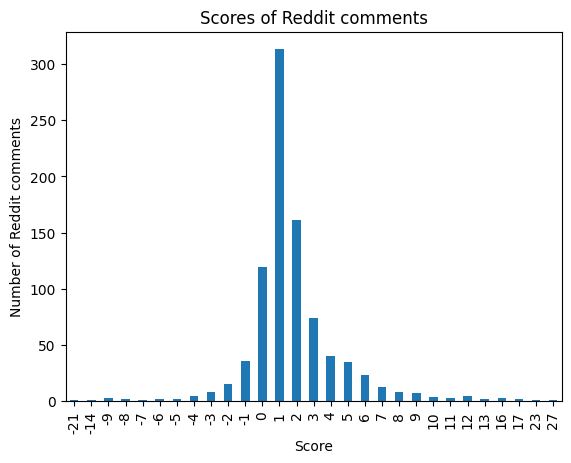

In [49]:
# Plots the scores of all the Reddit comments.
pandas_converted.plot.bar(x='score', y='count', legend=None)
plt.title('Scores of Reddit comments')
plt.ylabel('Number of Reddit comments')
plt.xlabel('Score')
plt.show()

From the above figure, we see that most of the Reddit comments has a score around 1.

## Calculating the sentiments 

In [50]:
# Converts the given score to either of the 2 sentiments: 0 (negative) if score < 0, or 1 (positive) if score > 0.
def sentiment(score):
    if score < 0:
        return 0
    if score > 0:
        return 1

# Defines an UDF for the sentiment() function
udf_sentiment = udf(lambda score: sentiment(score), IntegerType())

# Calculates the sentiment for each comment with neutral comments filtered out. 
comments = comments.filter(col('score') != 0).select(col('body'), udf_sentiment(col('score')).alias('sentiment'))

comments.show()

+--------------------+---------+
|                body|sentiment|
+--------------------+---------+
|A look at Vietnam...|        1|
|The site states "...|        1|
|Saft is by far th...|        1|
|How to take panor...|        1|
|I donât know wh...|        1|
|LinkIt by Marc, a...|        1|
|Making websites r...|        1|
|On the bright sid...|        1|
|Like a lot of peo...|        1|
|It's a New York T...|        1|
|[Here's the copy ...|        1|
|The best thing ab...|        1|
|You can rank the ...|        1|
|just testing this...|        0|
|_We didn't tortur...|        1|
|Interesting artic...|        1|
|reddit got a "run...|        1|
|this is wonderful...|        0|
|cool.  i love a g...|        0|
|Comments? About t...|        0|
+--------------------+---------+
only showing top 20 rows



## Visualizing Reddit comments in different sentiment classes

In [51]:
# Extracts the sentiments classes (negative and positive) and the number of comments in each sentiment class.
sentiments = comments.groupBy('sentiment').agg(count('body').alias('count')).sort('sentiment').collect()
negative = sentiments[0][1]
positive = sentiments[1][1]

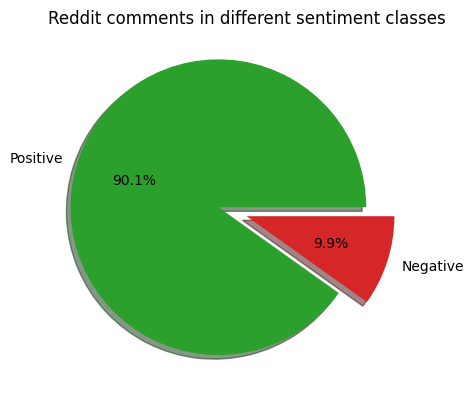

In [52]:
# Plots the sentiment classes and their corresponding counts. 
plt.pie([positive, negative], labels=['Positive', 'Negative'], explode = [0.2, 0], shadow = True, colors=['tab:green', 'tab:red'], autopct='%1.1f%%')
plt.title('Reddit comments in different sentiment classes')
plt.show()

## Pre-processing

In [53]:
# Pre-processes the comments.
def pre_process(comments):
    
    # Tokenization
    tokenizer = RegexTokenizer(inputCol="body", outputCol="tokens", pattern="\\W+")
    tokenized = tokenizer.transform(comments)
    
    # Stop words removal
    add_stopwords = ["http","https","amp","rt","t","c","the","@","/",":"] # standard web stop words
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens").setStopWords(add_stopwords)
    filtered = stopwords_remover.transform(tokenized)
    
    return filtered

In [54]:
# Preprocesses the comment in the Reddit dataset.
comments = pre_process(comments)
comments.show()

+--------------------+---------+--------------------+--------------------+
|                body|sentiment|              tokens|     filtered_tokens|
+--------------------+---------+--------------------+--------------------+
|A look at Vietnam...|        1|[a, look, at, vie...|[a, look, at, vie...|
|The site states "...|        1|[the, site, state...|[site, states, wh...|
|Saft is by far th...|        1|[saft, is, by, fa...|[saft, is, by, fa...|
|How to take panor...|        1|[how, to, take, p...|[how, to, take, p...|
|I donât know wh...|        1|[i, don, t, know,...|[i, don, know, wh...|
|LinkIt by Marc, a...|        1|[linkit, by, marc...|[linkit, by, marc...|
|Making websites r...|        1|[making, websites...|[making, websites...|
|On the bright sid...|        1|[on, the, bright,...|[on, bright, side...|
|Like a lot of peo...|        1|[like, a, lot, of...|[like, a, lot, of...|
|It's a New York T...|        1|[it, s, a, new, y...|[it, s, a, new, y...|
|[Here's the copy ...|   

## Feature Extraction
Using HashingTF() and IDF() to put features into a feature vector column. 

In [55]:
# Calculates term frequency (tf) for each of the tokens. 
hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=20)
tf = hashing_tf.transform(comments)

# Calculates term frequency–inverse document frequency (tf-idf) for each of the tokens. 
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(tf)
tfidf = idf_model.transform(tf)

tfidf.select(col('features'), col('sentiment')).show()

+--------------------+---------+
|            features|sentiment|
+--------------------+---------+
|(20,[1,2,7,10,11,...|        1|
|(20,[0,1,3,4,5,6,...|        1|
|(20,[0,1,3,6,9,13...|        1|
|(20,[1,2,3,8,15,1...|        1|
|(20,[0,1,2,4,5,6,...|        1|
|(20,[1,2,3,4,5,8,...|        1|
|(20,[0,1,2,4,6,8,...|        1|
|(20,[0,1,3,4,6,7,...|        1|
|(20,[0,1,2,3,4,5,...|        1|
|(20,[0,1,3,5,6,7,...|        1|
|(20,[0,1,2,3,5,6,...|        1|
|(20,[0,3,4,6,7,9,...|        1|
|(20,[0,10,11,13,1...|        1|
|(20,[7,9,13],[0.3...|        0|
|(20,[1,9,11,13,15...|        1|
|(20,[2,3,8,13,14,...|        1|
|(20,[0,1,3,4,5,6,...|        1|
|(20,[1,2,6,7,9,13...|        0|
|(20,[0,7,8,11,15,...|        0|
|(20,[0,3,6,8,9,11...|        0|
+--------------------+---------+
only showing top 20 rows



The result displays that the features have transformed into a Dense Vector.

We have generated enough information post preprocessing our data to feed it to the model. 

## Building A Logistic Regression Model With Spark ML
As we have finished the preprocessing of our data, now we build our Logistic Regression model. We first need to split the data into train and test sets, using the randomSplit() method:

In [56]:
# Sets random seed 
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [57]:
# Splits the data into train and test data
train_data, test_data = tfidf.randomSplit([.7,.3], seed=rnd_seed)

In [58]:
# Size of the train and test data
train_data.count(), test_data.count()

(537, 234)

**Now we create an Logistic Regression Model**

In [59]:
# Creates the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='sentiment', predictionCol='predicted_sentiment', 
                        maxIter=500, regParam=0.3, elasticNetParam=0.8, standardization=False)

In [60]:
# Fit the train data to the model
lr = lr.fit(train_data)

**Generate Predictions**

In [61]:
predictions = lr.transform(test_data)
predictions.select("predicted_sentiment", "sentiment").show(20)

+-------------------+---------+
|predicted_sentiment|sentiment|
+-------------------+---------+
|                1.0|        1|
|                1.0|        1|
|                1.0|        0|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
|                1.0|        1|
+-------------------+---------+
only showing top 20 rows



/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


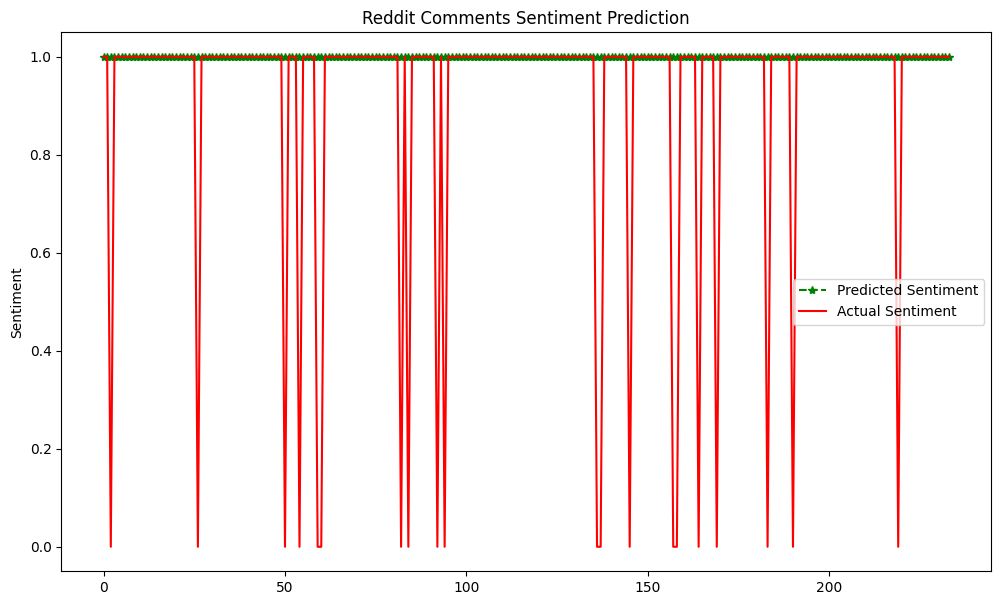

In [63]:
# Plotting the predicted sentiment vs the actual sentiment
plt.figure(figsize=(12,7))
pred_results=lr.evaluate(test_data)
Y = pred_results.predictions.select('predicted_sentiment').toPandas()
_Y = pred_results.predictions.select('sentiment').toPandas()
plt.plot(Y, color='green', marker='*', linestyle='dashed', 
         label='Predicted Sentiment')
plt.plot(_Y, color='red', label='Actual Sentiment')
plt.title('Reddit Comments Sentiment Prediction')
plt.ylabel('Sentiment')
plt.legend()

**Inspect the Metrics**

Now we look at some metrics to get a better idea of how good the model is performing using BinaryClassificationEvaluator.  

In [64]:
# Evaluate the model on test data
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='sentiment')
auc = evaluator.evaluate(predictions)
print("Area under ROC curve = %g" % auc)

Area under ROC curve = 0.5


In [65]:
tp = predictions[(predictions.sentiment == 1) & (predictions.predicted_sentiment == 1)].count()
tn = predictions[(predictions.sentiment == 0) & (predictions.predicted_sentiment == 0)].count()
fp = predictions[(predictions.sentiment == 0) & (predictions.predicted_sentiment == 1)].count()
fn = predictions[(predictions.sentiment == 1) & (predictions.predicted_sentiment == 0)].count()

print("True positive rate = %g" % (tp / (tp + fn)))
print("False positive rate = %g" % (fp / (fp + tn)))
print("Precision = %g" % (tp / (tp + fp)))
print("Recall = %g" % (tp / (tp + fn)))

True positive rate = 1
False positive rate = 1
Precision = 0.91453
Recall = 1


In [66]:
spark_session.stop() 

In [67]:
print(f'Execution time: {time.process_time() - start_time} seconds')

Execution time: 1.8079067100000001 seconds
